# Consultations

Tuesday 14:00 in S303

### After agreement: 

    Thirsday 14:00
    Friday 8:30

# Clustering, Principal Component Analysis

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cx_Oracle
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram,linkage,fcluster

max_movieid=500
max_userid=2000

n_clusters=6

## Load table RATS

In [2]:
cx_Oracle.init_oracle_client(config_dir="C:\\Users\\marta\\Desktop\\Plocha\\programy\\instantclient_21_8")

import warnings
warnings.simplefilter("ignore")

In [3]:
connection =cx_Oracle.connect(user='websem', password='websem108', 
                              dsn='tirpitz.ms.mff.cuni.cz:1511/jedenact.ms.mff.cuni.cz')
movies=pd.read_sql_query('select MOVIEID,TITLE,GENRE,TT from MMOVIES WHERE MOVIEID>3 AND MOVIEID<{}'.format(max_movieid),
                         connection)
connection =cx_Oracle.connect(user='websem', password='websem108', 
                              dsn='tirpitz.ms.mff.cuni.cz:1511/jedenact.ms.mff.cuni.cz')
ratings=pd.read_sql_query('''select MOVIEID,USERID,RATING,DT,DTYY,DTMM,DTDW,DTHH from MRATINGS 
                            WHERE MOVIEID<{} AND USERID<{}
                            ORDER BY MOVIEID, USERID
'''.format(max_movieid,max_userid)
                          ,connection)
rats=pd.merge(ratings, movies, how='inner', on="MOVIEID")
imdb=pd.read_sql_query('select TT,NAME,RATING as IMDBRATING,RATED,METASCORE,DIRECTOR,ACTORS,LANGUAGE,YEAR from IMDB',connection)
#rats.reset_index(inplace=True)
rats=pd.merge(rats,imdb, how='left',on='TT')
rats.head(1)

,MOVIEID,USERID,RATING,DT,DTYY,DTMM,DTDW,DTHH,TITLE,GENRE,TT,NAME,IMDBRATING,RATED,METASCORE,DIRECTOR,ACTORS,LANGUAGE,YEAR
0,4,41,2.0,2000-02-27 23:29:58,2000,2,1,23,Waiting to Exhale (1995),Comedy|Drama|Romance\r,tt0114885,Waiting to Exhale,5.6,R,NaN,Forest Whitaker,"Whitney Houston, Angela Bassett, Loretta Devin...",English,1995


In [4]:
rats.columns

Index(['MOVIEID', 'USERID', 'RATING', 'DT', 'DTYY', 'DTMM', 'DTDW', 'DTHH',
       'TITLE', 'GENRE', 'TT', 'NAME', 'IMDBRATING', 'RATED', 'METASCORE',
       'DIRECTOR', 'ACTORS', 'LANGUAGE', 'YEAR'],
      dtype='object')

## Columns for ech genre

genres    .... list of genres

In [5]:
import functools
sets=[set(u[:-1].split('|')) for u in rats.GENRE]
genres=list(functools.reduce(lambda x,y:x.union(y),sets))

In [6]:
genres

['Action',
 'Documentary',
 'Western',
 'Children',
 'War',
 'Sci-Fi',
 'Film-Noir',
 'Drama',
 'Fantasy',
 'Adventure',
 'Animation',
 'IMAX',
 'Thriller',
 'Crime',
 'Romance',
 'Musical',
 'Horror',
 'Mystery',
 'Comedy']

In [7]:
for i in genres:
    rats[i]=[a.find(i)>-1 for a in rats.GENRE]
rats.columns

Index(['MOVIEID', 'USERID', 'RATING', 'DT', 'DTYY', 'DTMM', 'DTDW', 'DTHH',
       'TITLE', 'GENRE', 'TT', 'NAME', 'IMDBRATING', 'RATED', 'METASCORE',
       'DIRECTOR', 'ACTORS', 'LANGUAGE', 'YEAR', 'Action', 'Documentary',
       'Western', 'Children', 'War', 'Sci-Fi', 'Film-Noir', 'Drama', 'Fantasy',
       'Adventure', 'Animation', 'IMAX', 'Thriller', 'Crime', 'Romance',
       'Musical', 'Horror', 'Mystery', 'Comedy'],
      dtype='object')

## groupby  ... again

for each user and genre, count the number of ratings;

better: ratings >3.5

In [8]:
user_genre_ratings=rats.groupby('USERID')[genres].sum()
user_genre_ratings

,Action,Documentary,Western,Children,War,Sci-Fi,Film-Noir,Drama,Fantasy,Adventure,Animation,IMAX,Thriller,Crime,Romance,Musical,Horror,Mystery,Comedy
USERID,,,,,,,,,,,,,,,,,,,
1,5,0,0,0,1,3,0,7,2,3,0,0,5,6,1,0,1,4,4
2,4,0,1,0,2,2,0,5,0,2,0,0,2,0,2,1,1,0,1
3,6,0,0,0,0,10,0,5,0,6,0,0,5,3,1,0,1,3,2
4,9,0,1,0,1,3,0,5,1,5,0,0,10,5,4,0,0,2,9
5,9,0,1,2,1,3,0,15,2,8,1,2,7,2,7,1,0,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,4,0,0,0,1,3,0,3,0,2,0,0,4,1,2,0,0,1,2
1995,6,0,1,2,1,2,0,8,1,4,0,1,8,6,3,0,0,1,7
1996,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [9]:
rats.columns

Index(['MOVIEID', 'USERID', 'RATING', 'DT', 'DTYY', 'DTMM', 'DTDW', 'DTHH',
       'TITLE', 'GENRE', 'TT', 'NAME', 'IMDBRATING', 'RATED', 'METASCORE',
       'DIRECTOR', 'ACTORS', 'LANGUAGE', 'YEAR', 'Action', 'Documentary',
       'Western', 'Children', 'War', 'Sci-Fi', 'Film-Noir', 'Drama', 'Fantasy',
       'Adventure', 'Animation', 'IMAX', 'Thriller', 'Crime', 'Romance',
       'Musical', 'Horror', 'Mystery', 'Comedy'],
      dtype='object')

calculate the relative values, that sum up to 1 for each user.

use broadcasting
https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html

In [10]:
sums=user_genre_ratings.sum(axis=1)
sums #one dimensional array ('not a column vector')

USERID
1       42
2       23
3       42
4       55
5       72
        ..
1993    23
1995    51
1996     2
1997    39
1998    62
Length: 1960, dtype: int64

In [11]:
np.array(sums)[:, np.newaxis] #new axis, array of one-dimensional arrays

array([[42],
       [23],
       [42],
       ...,
       [ 2],
       [39],
       [62]], dtype=int64)

In [12]:
user_genre_proportions=user_genre_ratings/np.array(sums)[:, np.newaxis]
user_genre_proportions

,Action,Documentary,Western,Children,War,Sci-Fi,Film-Noir,Drama,Fantasy,Adventure,Animation,IMAX,Thriller,Crime,Romance,Musical,Horror,Mystery,Comedy
USERID,,,,,,,,,,,,,,,,,,,
1,0.119048,0.0,0.000000,0.000000,0.023810,0.071429,0.0,0.166667,0.047619,0.071429,0.000000,0.000000,0.119048,0.142857,0.023810,0.000000,0.023810,0.095238,0.095238
2,0.173913,0.0,0.043478,0.000000,0.086957,0.086957,0.0,0.217391,0.000000,0.086957,0.000000,0.000000,0.086957,0.000000,0.086957,0.043478,0.043478,0.000000,0.043478
3,0.142857,0.0,0.000000,0.000000,0.000000,0.238095,0.0,0.119048,0.000000,0.142857,0.000000,0.000000,0.119048,0.071429,0.023810,0.000000,0.023810,0.071429,0.047619
4,0.163636,0.0,0.018182,0.000000,0.018182,0.054545,0.0,0.090909,0.018182,0.090909,0.000000,0.000000,0.181818,0.090909,0.072727,0.000000,0.000000,0.036364,0.163636
5,0.125000,0.0,0.013889,0.027778,0.013889,0.041667,0.0,0.208333,0.027778,0.111111,0.013889,0.027778,0.097222,0.027778,0.097222,0.013889,0.000000,0.013889,0.138889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,0.173913,0.0,0.000000,0.000000,0.043478,0.130435,0.0,0.130435,0.000000,0.086957,0.000000,0.000000,0.173913,0.043478,0.086957,0.000000,0.000000,0.043478,0.086957
1995,0.117647,0.0,0.019608,0.039216,0.019608,0.039216,0.0,0.156863,0.019608,0.078431,0.000000,0.019608,0.156863,0.117647,0.058824,0.000000,0.000000,0.019608,0.137255
1996,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000


In [13]:
user_genre_proportions.sum(axis=1)

USERID
1       1.0
2       1.0
3       1.0
4       1.0
5       1.0
       ... 
1993    1.0
1995    1.0
1996    1.0
1997    1.0
1998    1.0
Length: 1960, dtype: float64

# KMeans clustering


In [14]:
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(user_genre_proportions)
y_kmeans = kmeans.predict(user_genre_proportions)

In [15]:
y_kmeans

array([0, 2, 1, ..., 4, 1, 1])

### Histogram

In [43]:
np.histogram(y_kmeans,bins=(n_clusters))

(array([231, 861, 600,  17,  42, 209], dtype=int64),
 array([0.        , 0.83333333, 1.66666667, 2.5       , 3.33333333,
        4.16666667, 5.        ]))

### Cluster centers

In [17]:
kmeans.cluster_centers_

array([[ 7.45129250e-02,  5.70511420e-03,  4.56898254e-03,
         8.36699649e-03,  1.87978871e-02,  3.67803045e-02,
         1.32064418e-03,  1.99627427e-01,  1.11755894e-02,
         3.11187410e-02,  1.81261603e-03,  3.95643574e-03,
         1.95374111e-01,  1.84576092e-01,  2.96770084e-02,
         2.40012376e-03,  1.15706302e-02,  8.43472280e-02,
         9.43111442e-02],
       [ 1.62062388e-01,  1.15219874e-03,  8.15119000e-03,
         2.07696412e-02,  2.43896928e-02,  8.25667573e-02,
         5.47851703e-04,  1.20973625e-01,  1.94177090e-02,
         1.11939501e-01,  5.73858013e-03,  9.89433537e-03,
         1.37082537e-01,  7.58948019e-02,  5.09326200e-02,
         6.95652104e-03,  1.22816017e-02,  2.73637087e-02,
         1.21884739e-01],
       [ 8.71677683e-02,  4.27810486e-03,  9.55701157e-03,
         3.39627299e-02,  3.86201441e-02,  3.93454259e-02,
         5.46306743e-04,  2.35637708e-01,  1.73772810e-02,
         6.89259010e-02,  1.07603146e-02,  1.33885865e-02,
    

In [36]:
print(user_genre_proportions.columns[18])
kmeans.cluster_centers_[:,18]

Comedy


array([0.09431114, 0.12188474, 0.1346338 , 0.94607843, 0.02156085,
       0.28958491])

### My selected genre indexes to plot

In [46]:
action_idx=np.where(user_genre_proportions.columns=='Action')[0][0]
comedy_idx=np.where(user_genre_proportions.columns=='Comedy')[0][0]
drama_idx=np.where(user_genre_proportions.columns=='Drama')[0][0]
print('comedy_idx={}'.format(comedy_idx))

comedy_idx=18


## The simplest graph

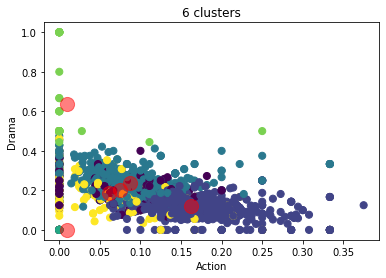

In [20]:
plt.scatter(user_genre_proportions.Action, user_genre_proportions.Drama, 
            c=y_kmeans, s=50, cmap='viridis')
plt.xlabel('Action')
plt.ylabel('Drama')
plt.title('{} clusters'.format(n_clusters))

centers = kmeans.cluster_centers_
plt.scatter(centers[:,action_idx], centers[:,drama_idx], c='red', s=200, alpha=0.5)

### Zoom in

(-0.01, 0.4)

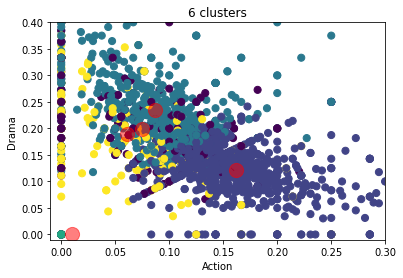

In [21]:
plt.scatter(user_genre_proportions.Action, user_genre_proportions.Drama, c=y_kmeans, s=50, cmap='viridis')
plt.xlabel('Action')
plt.ylabel('Drama')
plt.title('{} clusters'.format(n_clusters))

centers = kmeans.cluster_centers_
plt.scatter(centers[:,action_idx], centers[:,drama_idx], c='red', s=200, alpha=0.5)
plt.xlim(-0.01,0.3)
plt.ylim(-0.01,0.4)


# Principal Componenet Analysis


PCA finds the best 2 directions to plot

In [22]:
n_components=2

pca = PCA(n_components=n_components)
pca.fit(user_genre_proportions)

PCA(n_components=2)

https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

In [49]:
print("Principal components\n{}".format(pca.components_))
print('Explained variance: {}'.format(pca.explained_variance_))

Principal components
[[-3.29431562e-01  1.15957207e-02 -1.19891132e-02 -6.35516524e-03
   3.05882116e-02 -1.92260355e-01  1.63876465e-05  8.35860590e-01
  -3.13817754e-02 -2.35695079e-01  7.45379308e-04  1.71103136e-03
  -1.04805674e-01  1.70098327e-01  9.75767836e-02  1.59707991e-03
  -1.24308895e-02 -5.37557528e-03 -2.20064322e-01]
 [-2.48860486e-01  4.55339256e-03  3.19096127e-03  2.71014115e-02
   1.15399680e-02 -1.71518486e-01 -2.21755754e-03  1.41125021e-02
   7.71967160e-03 -1.65801751e-01  2.26130238e-05 -7.49641109e-03
  -2.71496314e-01 -1.72631238e-01  2.18952781e-01  2.86304418e-03
  -1.40468285e-02 -8.51263042e-02  8.49139030e-01]]
Explained variance: [0.01620807 0.01535463]


### Main PCA directions

name of the column with the maximal value

In [24]:
for i in range(n_components):
    print(user_genre_proportions.columns[list(pca.components_[i]).index(max(abs(pca.components_[i])))])

Drama
Comedy


### The most important genres in clusters

In [25]:
for i in np.arange(n_clusters):
    print(user_genre_proportions.columns[list(centers[i]).index(max(abs(centers[i])))])

Drama
Action
Drama
Comedy
Drama
Comedy


### Transform the cluster centres to PCA coordinates

In [26]:
X_pca = pca.transform(user_genre_proportions)
centers_pca = pca.transform(centers)

### The graph in the new coordinates

the clusters are more spread out

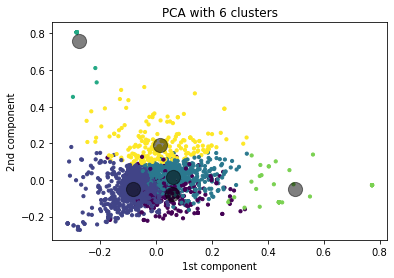

In [27]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, s=10, cmap='viridis')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.title('PCA with {} clusters'.format(n_clusters))

plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', s=200, alpha=0.5)
plt.show()

### Plotting clusters one by one

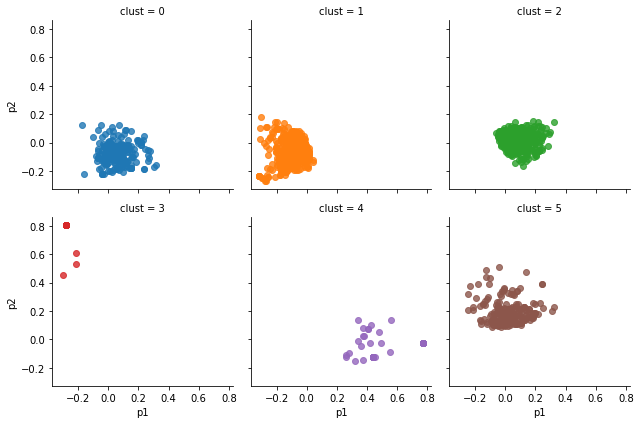

In [28]:
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
pca_df=pd.DataFrame({'p1':X_pca[:, 0], 'p2':X_pca[:, 1],'clust':y_kmeans})
sns.lmplot('p1','p2' ,data=pca_df, hue='clust',col='clust', fit_reg=False, col_wrap=3, height=3)

## Hierarchical Clustering

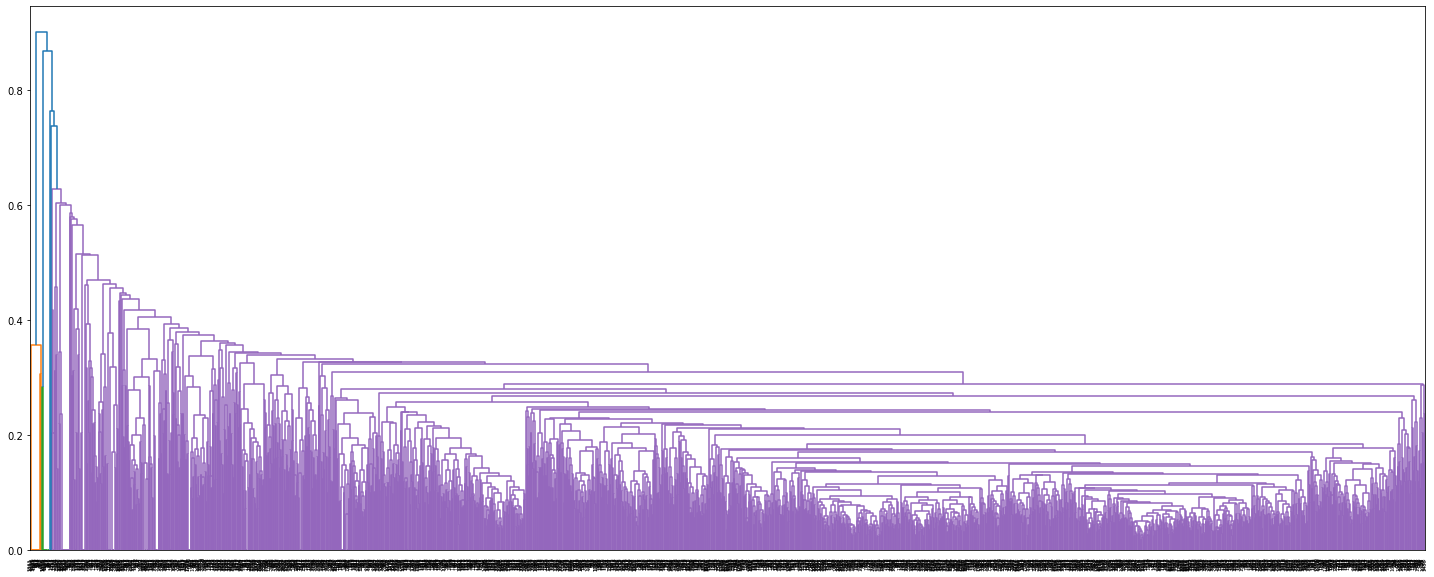

In [29]:
Z = linkage(user_genre_proportions, 'average')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

plt.show()

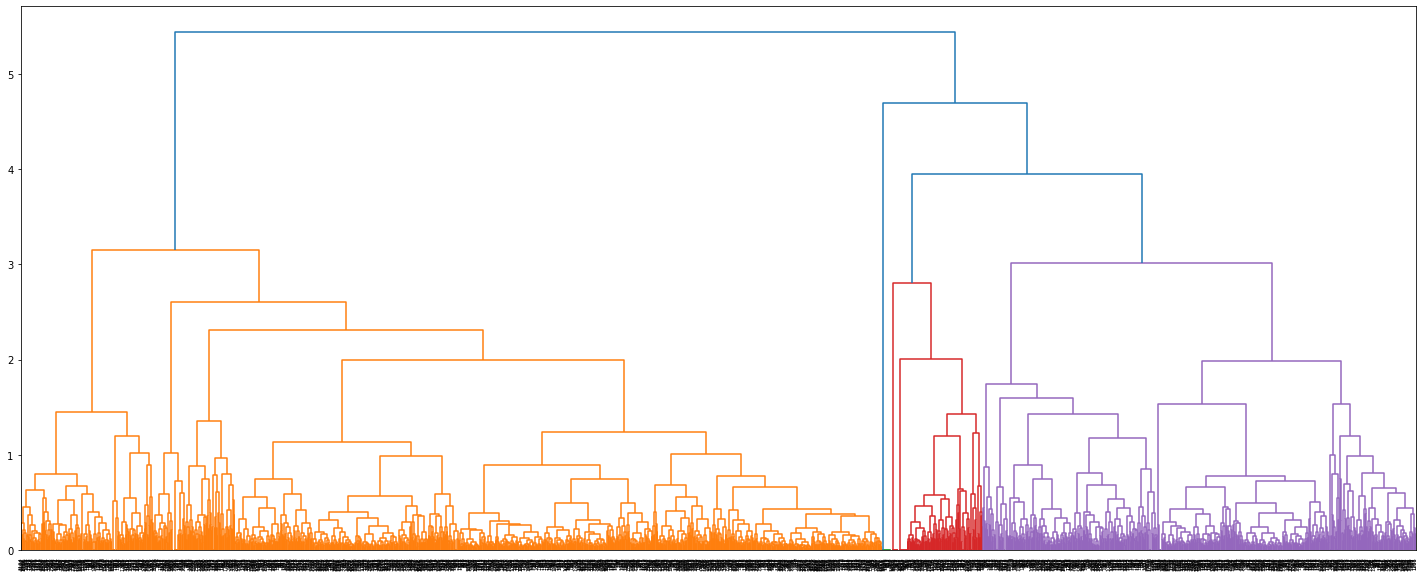

In [30]:
Z = linkage(user_genre_proportions, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

plt.show()

## Cut for the specific number of clusters

(or the depth)

In [52]:
f_cluster=fcluster(Z, t=n_clusters, criterion='maxclust', depth=3)
f_cluster

array([1, 6, 2, ..., 4, 2, 2], dtype=int32)

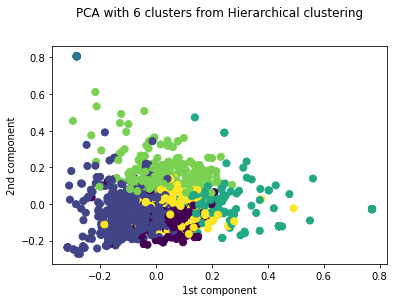

In [53]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=f_cluster, s=50, cmap='viridis')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.title('PCA with {} clusters from Hierarchical clustering'.format(n_clusters))
plt.show()

### Comparison of the k-means and aggomerative clusters

In [33]:
clust_comp=pd.DataFrame({'agg':f_cluster, 'kmean':y_kmeans})
clust_comp.groupby(['agg','kmean'])['kmean'].count().unstack().fillna(0)

kmean,0,1,2,3,4,5
agg,,,,,,
1,147.0,14.0,26.0,0.0,0.0,0.0
2,46.0,812.0,138.0,0.0,0.0,27.0
3,0.0,0.0,0.0,14.0,0.0,0.0
4,23.0,0.0,62.0,0.0,37.0,6.0
5,8.0,6.0,53.0,3.0,0.0,175.0
6,7.0,29.0,321.0,0.0,5.0,1.0


### Silhouette for the number of clusters

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

For n_clusters = 2 The average silhouette_score is : 0.2225651134022108
For n_clusters = 6 The average silhouette_score is : 0.13476874791883706
For n_clusters = 10 The average silhouette_score is : 0.12285950488801414
For n_clusters = 14 The average silhouette_score is : 0.12542154662223107


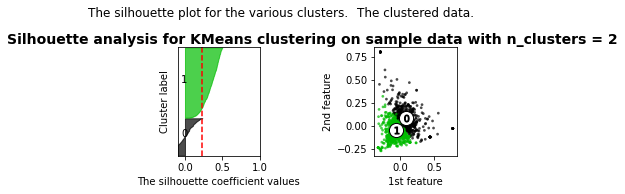

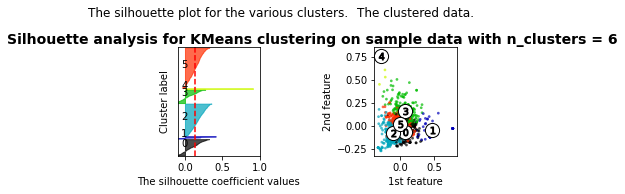

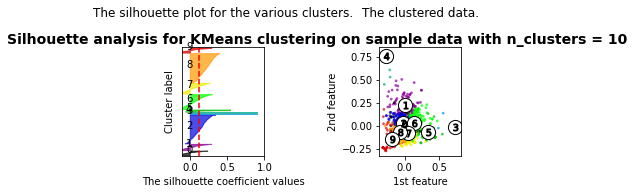

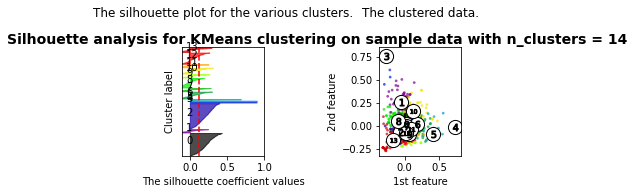

In [54]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from matplotlib import rcParams
rcParams['axes.titlepad'] = 30

X=user_genre_proportions
range_n_clusters = np.arange(2,15, step=4)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.subplots_adjust(hspace=3.4, wspace=1.4)
    #fig.subplots_adjust(top=0.95)
    #fig.tight_layout()
    fig.set_size_inches(5, 2)
    ax1.set_xlim([-0.1, 1])

    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([ 0,  0.5,  1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    centers_pca = pca.transform(centers)

    # Draw white circles at cluster centers
    ax2.scatter(centers_pca[:,0], centers_pca[:,1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers_pca):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The clustered data.")
    ax2.set_xlabel("1st feature")
    ax2.set_ylabel("2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
#    plt.savefig(pp,format='pdf')
#pp.close()
plt.show()

# Select one task and evaluate clustering

1. clustering of users given their genre preferences; 
        any rating >3.5 is taken as 'like'

4. cluster the genres into 5 groups
5. cluster languages into 5 groups
3. directors based on number of positive/negative ratings and genre.